In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np
from deepBreaks.utils import load_obj


In [3]:
# --- Configuration ---
model_path = './wt_mnm_gbr.pkl'  # Path to your saved GBR model
TREE_INDEX_TO_PLOT = 0            # Index of the tree you want to visualize (e.g., 0 for the first tree)
# Provide the feature names used during training for better plot interpretation
# If trained on a pandas DataFrame 'X_train', this would be list(X_train.columns)
MAX_DEPTH_VIZ = 6                 # Limit plot depth for clarity (optional)


In [4]:
gbr_model = load_obj(model_path)

Accessing tree at index 0
Plotting tree 0...


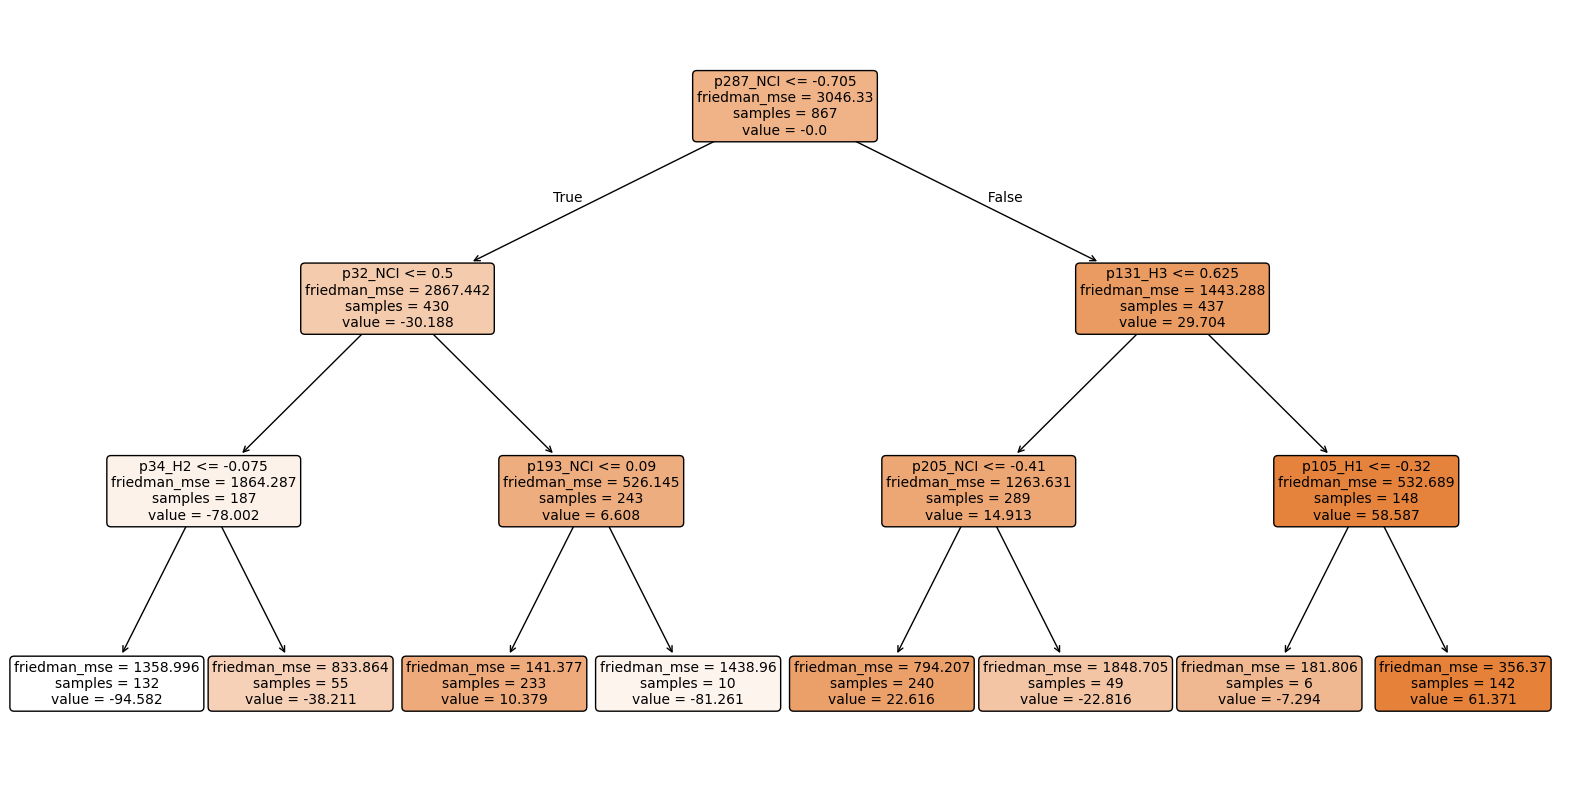

In [5]:
# --- Access the Specific Tree ---
if hasattr(gbr_model[1], 'estimators_') and gbr_model[1].estimators_.size > 0:
    if TREE_INDEX_TO_PLOT < len(gbr_model[1].estimators_):
        # Extract the specific tree regressor object
        tree_to_plot = gbr_model[1].estimators_[TREE_INDEX_TO_PLOT, 0]
        print(f"Accessing tree at index {TREE_INDEX_TO_PLOT}")
    else:
        print(f"Error: TREE_INDEX_TO_PLOT ({TREE_INDEX_TO_PLOT}) is out of bounds.")
        print(f"Model has {len(gbr_model.estimators_)} trees.")
else:
    print("Error: Could not find estimators_ attribute or it's empty. Was the model fitted?")

# --- Visualize the Tree ---
print(f"Plotting tree {TREE_INDEX_TO_PLOT}...")
plt.figure(figsize=(20, 10)) # Adjust figure size as needed

plot_tree(tree_to_plot,
          filled=True,           # Color nodes by majority class/value
          rounded=True,          # Use rounded boxes
          precision=3,           # Number of digits for values
          fontsize=10,           # Font size
          max_depth=MAX_DEPTH_VIZ, # Limit the depth shown,
          feature_names=gbr_model[0][4].get_names_out()
         )

#plt.title(f"Decision Tree {TREE_INDEX_TO_PLOT} from GBR Model (Max Depth Shown: {MAX_DEPTH_VIZ})")
plt.show()

In [ ]:
import re
import joblib
import graphviz
import matplotlib.pyplot as plt
import xgboost as xgb
from deepBreaks.utils import load_obj

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [38]:
# --- Configuration ---
aap_model_path = 'vert_xgb_aa_prop.pkl'   # Path to saved XGBoost model trained using AA_Prop encoding
oh_model_path = 'vert_xgb_one_hot.pkl'  # Path to saved XGBoost model trained using 
tree_index_to_plot = 0  # Index of the tree to visualize
rankdir='LR'  # 'TB' (top-to-bottom) or 'LR' (left-to-right) layout

In [40]:
# --- Define Custom Graphviz Attributes ---
# Note: Values must often be strings
condition_node_params = {
    'fontname': 'Century Gothic', # Or 'Arial', 'Times New Roman', etc. (must be installed)
    'fontsize': '10',
    'shape': 'box',         # Node shape
    'style': 'filled, rounded', # Fill nodes and use rounded corners
    'fillcolor': '#FDF4D9', # Default node fill color
    'color': '#FBE9B1',       # Edge line color
    'fontcolor': 'black',     # Node text color 
    'penwidth': '2',       # Edge line width (e.g., '0.5', '2.0')
    'arrowsize': '2'     # Size of the arrowheads
}  

leaf_node_params = {
    'fontname': 'Century Gothic',
    'fontsize': '10',
    'style': 'filled, rounded', # Fill nodes and use rounded corners
    'fillcolor': '#DDFBD2', # Default node fill color
    'color': '#B8F6A2',     # Node border color
    'penwidth': '2',       # Edge line width (e.g., '0.5', '2.0')
    'arrowsize': '2'     # Size of the arrowheads
}

In [41]:
def round_split_value(match, decimal_places = 2):
    # Extract the captured groups from the regex
    prefix = match.group(1)       # The part before the number (e.g., 'label="Feature_X<')
    number_str = match.group(2)   # The number as a string (e.g., '3.14159')
    try:
        # Convert the number string to a float and round it
        value = float(number_str)
        rounded_value = round(value, decimal_places)
        # Format the rounded value back to a string with the desired precision
        # Using f-string formatting ensures trailing zeros (e.g., 2.50)
        formatted_rounded_value = f'{rounded_value:.{decimal_places}f}'

        # Reconstruct the label string
        if 'leaf=' in prefix:
            prefix = prefix.replace('leaf=','')
            if '-' in formatted_rounded_value: 
                return f"{prefix}{formatted_rounded_value}nm"
            else:
                return f"{prefix}+{formatted_rounded_value}nm"

        else:
            return f"{prefix}{formatted_rounded_value}"
    except ValueError:
        # If conversion fails for some reason, return the original match
        return match.group(0)

In [51]:
def draw_xgb_decision_tree(model_path, tree_index_to_plot=0, rankdir='LR'):
     # --- Load the Model ---
     try:
          xgb_model = joblib.load(model_path)
          print(f"Model loaded successfully from {model_path}")
     except FileNotFoundError:
          print(f"Error: Model file not found at {model_path}")
     except Exception as e:
          print(f"Error loading models: {e}")
     
     # --- Access the Booster object (since we are using the scikit-learn wrapper) ---
     if hasattr(xgb_model[1], 'get_booster'):
          booster = xgb_model[1].get_booster()
          print("Accessed Boosters object using get_booster()")
     else:
          print("Error: Loaded model doesn't seem to be an XGBoost model or wrapper with get_booster().")
          
     # --- Draw a tree from the booster ensemble ---
     try:
          gv_source = xgb.to_graphviz(booster,
                                   num_trees=tree_index_to_plot,
                                   rankdir=rankdir, # Default layout direction is LR (Left-to-Right)
                                   yes_color='#F4562A',
                                   no_color='#14BDEB',
                                   condition_node_params=condition_node_params,
                                   leaf_node_params=leaf_node_params,
                                   size='16,30',
                                   fontname='Century Gothic',
                                   #label = f"Decision Tree {TREE_INDEX_TO_PLOT} from AA-Prop XGBoost Model", #I dont like plot titles
                                   #labelloc = 't', # This will put the plot title at the top
                                   #ratio = 'fill', 
                                   
                                   )
          # Removing redundant labels and changing font
          modified_dot_source = gv_source.source.replace('label="yes" ','')
          modified_dot_source = modified_dot_source.replace('label="no, missing" ','')
          modified_dot_source = modified_dot_source.replace('0 -> 1 [color="#14BDEB"]','0 -> 1 [label="yes" color="#14BDEB" fontname="Century Gothic"]')
          modified_dot_source = modified_dot_source.replace('0 -> 2 [color="#F4562A"]','0 -> 2 [label="no" color="#F4562A" fontname="Century Gothic"]')
          
          # Rounding the values at nodes and leaves to two decimal places
          node_pattern = re.compile(r'(\[ label=".*?\s*[<>=]=?\s*)([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
          
          modified_dot_source2 = node_pattern.sub(round_split_value, modified_dot_source)
          modified_graph = graphviz.Source(modified_dot_source2)
              
          # --- Render the Graphviz object to SVG ---
          # The graphviz object has a 'render' method, but we can directly pipe to SVG format
          # The format='svg' directs the underlying Graphviz engine to output SVG data.
          # The pipe method returns the SVG data as bytes.
          svg_data = modified_graph.pipe(format='svg')
          output_file_base = f'{model_path.split(".")[0]}_tree{tree_index_to_plot}'
          output_svg = f'{output_file_base}.svg' # Output file name

          # --- Save the SVG data to a file ---
          with open(output_svg, 'wb') as f: # Open in binary write mode
               f.write(svg_data)
          print(f"Tree {tree_index_to_plot} saved directly to {output_svg} using graphviz")
          
          modified_graph.render(output_file_base, format='png', view=True, cleanup=True) # Renders PNG and tries to open it
     except ImportError:
          print("Error: plot_tree requires graphviz to be installed.")
          print("1. Install graphviz Python package: pip install graphviz")
          print("2. Install graphviz system software: https://graphviz.org/download/")
     except Exception as e:
          print(f"Error during plotting: {e}")

In [50]:
# --- Visualize the One-Hot Trees ---
print(f"Plotting tree {TREE_INDEX_TO_PLOT} for One-Hot Vert Model...")
draw_xgb_decision_tree(model_path=oh_model_path, tree_index_to_plot=tree_index_to_plot, rankdir=rankdir)

Plotting tree 0 for One-Hot Vert Model...
[12:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Model loaded successfully from vert_xgb_one_hot.pkl
Accessed Boosters object using get_booster()
Tree 0 saved directly to vert_xgb_one_hot_tree0.svg using graphviz


In [44]:
# --- Visualize the AA-Prop Trees ---
print(f"Plotting tree {TREE_INDEX_TO_PLOT} for AA-Prop Vert Model...")
draw_xgb_decision_tree(model_path=aap_model_path, tree_index_to_plot=tree_index_to_plot, rankdir=rankdir)

Plotting tree 0 for AA-Prop Vert Model...
[12:22:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Model loaded successfully from vert_xgb_aa_prop.pkl
Accessed Boosters object using get_booster()
Tree 0 saved directly to vert_xgb_aa_prop_tree0.svg using graphviz
